## Initializations

In [1]:
!ln -s ../fastai/

ln: failed to create symbolic link './fastai': File exists


In [1]:
%reload_ext autoreload
%autoreload 2

In [12]:
!pip install torchtext

    100% |████████████████████████████████| 51kB 410kB/s ta 0:00:01
  Running setup.py bdist_wheel for torchtext ... done
  Stored in directory: /Users/vinodreddy/Library/Caches/pip/wheels/42/a6/f4/b267328bde6bb680094a0c173e8e5627ccc99543abded97204
Successfully built torchtext


In [13]:
from fastai.conv_learner import *

In [14]:
sz = 105

## Model Definition

In [15]:
class Basenet(nn.Module):
    def __init__(self):
        super().__init__()

        
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=7, padding=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            
            nn.Conv2d(8, 16, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16),
            
            nn.Conv2d(16, 32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 32, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            
            nn.Conv2d(64, 64, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
        )
        
        self.drop = nn.Dropout(0.5)
        
        self.max_pool = nn.AdaptiveMaxPool2d((4,4))
        self.avg_pool = nn.AdaptiveAvgPool2d((4,4))
        self.lin = nn.Linear(2048, 100)
        
    
    def forward(self, x):
        x = self.cnn(x)
        ax = self.avg_pool(x).view((x.shape[0], -1))
        mx = self.max_pool(x).view((x.shape[0], -1))
        x = torch.cat([ax, mx], dim=1)
        x = F.relu(self.lin(x))
        return x
        
class SiameseNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = Basenet()
        self.lin = nn.Linear(100, 2)
    
    def forward(self, x1, x2):
        x1, x2 = self.base(x1), self.base(x2)
        x = torch.abs(x1-x2)
        return F.log_softmax(self.lin(x), dim=-1)

In [16]:
b = Basenet()
model_summary(b, (3,105,105))

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 105, 105]),
                           ('output_shape', [-1, 8, 105, 105]),
                           ('trainable', True),
                           ('nb_params', 1184)])),
             ('ReLU-2',
              OrderedDict([('input_shape', [-1, 8, 105, 105]),
                           ('output_shape', [-1, 8, 105, 105]),
                           ('nb_params', 0)])),
             ('BatchNorm2d-3',
              OrderedDict([('input_shape', [-1, 8, 105, 105]),
                           ('output_shape', [-1, 8, 105, 105]),
                           ('trainable', True),
                           ('nb_params', 16)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 8, 105, 105]),
                           ('output_shape', [-1, 16, 105, 105]),
                           ('trainable', True),
                           ('nb_params', 3216)])),
             ('ReLU-5',
              Ord

In [17]:
snet = SiameseNet()

In [18]:
tfms = tfms_from_stats(inception_stats, sz, crop_type=CropType.NO, aug_tfms=[RandomRotateZoom(10, 1.1, 1.1)])
data = ImageClassifierData.from_paths('./data/', bs=32, tfms=tfms, is_siamese=True, val_name='test')

In [19]:
learn = Learner.from_model_data(snet, data)

In [20]:
learn.crit = F.nll_loss

In [21]:
learn.metrics = [accuracy]

In [22]:
learn.lr_find()
learn.sched.plot()

A Jupyter Widget

 82%|████████▏ | 144/175 [08:55<01:55,  3.72s/it, loss=7.38] 

In [25]:
learn.fit(0.01, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

 31%|███▏      | 55/175 [00:07<00:16,  7.48it/s, loss=0.673]

Exception in thread Thread-20:
Traceback (most recent call last):
  File "/opt/conda/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/opt/conda/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/opt/conda/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                    
    0      0.60905    0.542019   0.769464  
    1      0.508191   0.379755   0.8525                      
    2      0.410546   0.357202   0.860893                    
    3      0.434759   0.313215   0.87625                     
    4      0.356688   0.284568   0.884286                    
    5      0.296284   0.251317   0.899821                    
    6      0.260418   0.242822   0.903214                    



[array([0.24282]), 0.9032142857142857]

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 78%|███████▊  | 137/175 [00:18<00:05,  7.54it/s, loss=0.982]

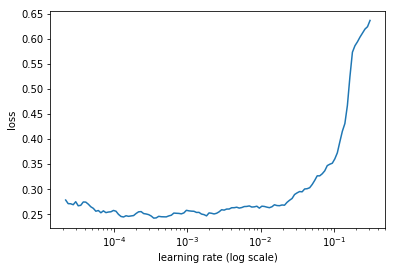

In [26]:
learn.lr_find()
learn.sched.plot()

In [27]:
learn.fit(0.0001, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

 35%|███▌      | 62/175 [00:08<00:15,  7.51it/s, loss=0.256]

Exception in thread Thread-28:
Traceback (most recent call last):
  File "/opt/conda/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/opt/conda/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/opt/conda/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                    
    0      0.257741   0.242011   0.904821  
    1      0.235618   0.240923   0.905179                    
    2      0.240564   0.240995   0.90375                     
    3      0.251608   0.23862    0.907143                    
    4      0.238753   0.238763   0.904464                    
    5      0.238443   0.237216   0.908929                    
    6      0.236408   0.237641   0.907679                    



[array([0.23764]), 0.9076785714285714]

In [32]:
learn.set_data(data)

In [34]:
lprobs = learn.predict()

In [36]:
learn.data.val_dl

AttributeError: 'SiameseDataset' object has no attribute 'y'